/Users/davidangeles/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



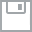
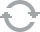
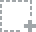
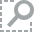
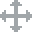
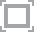
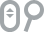
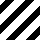
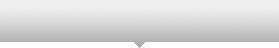
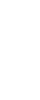
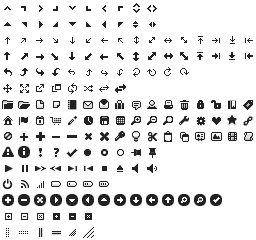
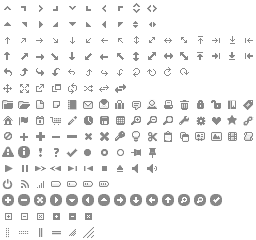
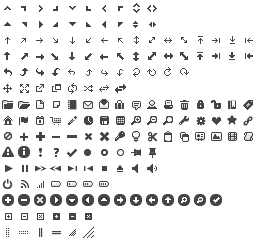
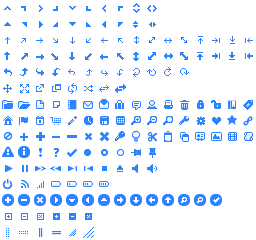
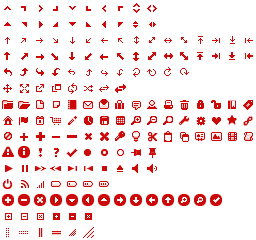
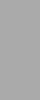
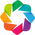
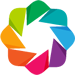

In [2]:
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.stats as st

# Import pyplot for plotting
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Import Bokeh modules for interactive plotting
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting

# Display graphics in this notebook
bokeh.io.output_notebook()

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.utils.extmath import cartesian

import networkx as nx

In [3]:
fname= '../input/c_elegans_gene_interactions.txt'
maxL= 0
i= 0
with open(fname, 'r') as f:
    for line in f:
        if line[0] != '#':
            l= line.split('\t') 
            if len(l) > maxL:
                maxL= len(l)

print(maxL) #as of Jan 1, 2016, maxL was 44 -- this is the number of rows in the df

44


In [4]:
maxL= 44
fname= '../input/c_elegans_gene_interactions.txt'
series= []
with open(fname, 'r') as f:
    for line in f:
        if line[0] != '#':
            line= line.rstrip()
            l= line.split('\t') 
            empty= [np.nan]*(maxL - len(l))
            l= l+empty
            series.append(l)
df= pd.DataFrame(data= series)
        

In [5]:
# WBInteractionID	Interaction_type	Interaction_subtype	Summary	Citation	Interactor1	Common-name	Role1	Interactor2	Common-name	Role2	...
columns_main= ['WBInteractionID', 'interaction_type', 'interaction_subtype', 'summary', 'citation']
column_repeat= ['interactor','common_name','role']

In [6]:
columns_sub= []
columns_sub_no_name= []

#max number of interactors in this df
maxInteractors= (maxL - len(columns_main))/len(column_repeat)


for i in np.arange(1, maxInteractors+1):
    for word in column_repeat:
        word= word+str(int(i))
        columns_sub= columns_sub+[word]
        if word != 'common_name'+str(int(i)):
            columns_sub_no_name= columns_sub_no_name+[word]

columns= columns_main+columns_sub

In [7]:
#try to clean up the 
maxL= 44
fname= '../input/c_elegans_gene_interactions.txt'
series= []

with open(fname, 'r') as f:
    for line in f:
        c= []
        
        if line[0] != '#':  
            
            line= line.rstrip()
            l= line.split('\t') 
            keys= columns[0:len(l)]
            d= dict(zip(keys, l))
            
            if d['interaction_type'] == 'Regulatory':
                
            
                eff_indices= np.where(np.array([x == 'Trans_regulator' for x in l]))[0]
                aff_indices= np.where(np.array([x == 'Trans_regulated' for x in l]))[0]
                
                d= dict(zip(keys, l))
                interactors= (len(l) - len(columns_main))/3

                #if no multiple interactors, assume it's autoregulatory
                #only accept trans_regulator roles:
                if interactors == 1 and d['role1'] == 'Trans_regulator':
                    
                    
                    d['role1']= 'Trans_regulated' #to denote auto-regulation
                    mykeys= ['interactor1','common_name1','role1']
                    add= [d[x] for x in mykeys]
                    
                    c= l+add      
                    series.append(c)
                    
                else:
                    
                    
                    combos= cartesian([eff_indices, aff_indices])
                    #print(aff_indices)
                    for pair in combos:
                        eff_ind= pair[0]
                        aff_ind= pair[1]
                        
                        #info on the effector:
                        effector= l[eff_ind-2:eff_ind+1]
                        affector= l[aff_ind-2: aff_ind+1]
                        
                        
                        c= l[:len(columns_main)] + effector + affector
                        series.append(c)

cols= columns_main+ ['interactor1','common_name1','role1']+['interactor2','common_name2','role2']
df= pd.DataFrame(data= series, columns= cols)
        

In [8]:
df= df.drop(['interaction_type', 'interaction_subtype', 'summary', 'citation'],1)
df.head()

,WBInteractionID,interactor1,common_name1,role1,interactor2,common_name2,role2
0,WBInteraction000003067,WBGene00003003,lin-14,Trans_regulator,WBGene00001080,dpy-21,Trans_regulated
1,WBInteraction000003068,WBGene00001085,dpy-26,Trans_regulator,WBGene00003003,lin-14,Trans_regulated
2,WBInteraction000003069,WBGene00001086,dpy-27,Trans_regulator,WBGene00003003,lin-14,Trans_regulated
3,WBInteraction000003070,WBGene00001087,dpy-28,Trans_regulator,WBGene00003003,lin-14,Trans_regulated
4,WBInteraction000003071,WBGene00006962,xol-1,Trans_regulator,WBGene00004745,sdc-1,Trans_regulated


In [9]:
df.shape

(7249, 7)

In [10]:
g= nx.from_pandas_dataframe(df, 'interactor1', 'interactor2', nx.DiGraph())

In [11]:
#degreeness of the network
val= np.array([])
for key, value in nx.degree(g).items():
    if np.size(val)== 0:
        val= np.array(value)
    else:
        val= np.append(val, value)
    if value == 0:
        print('uhoh')
        
print(val)


[1 1 3 ..., 2 1 4]


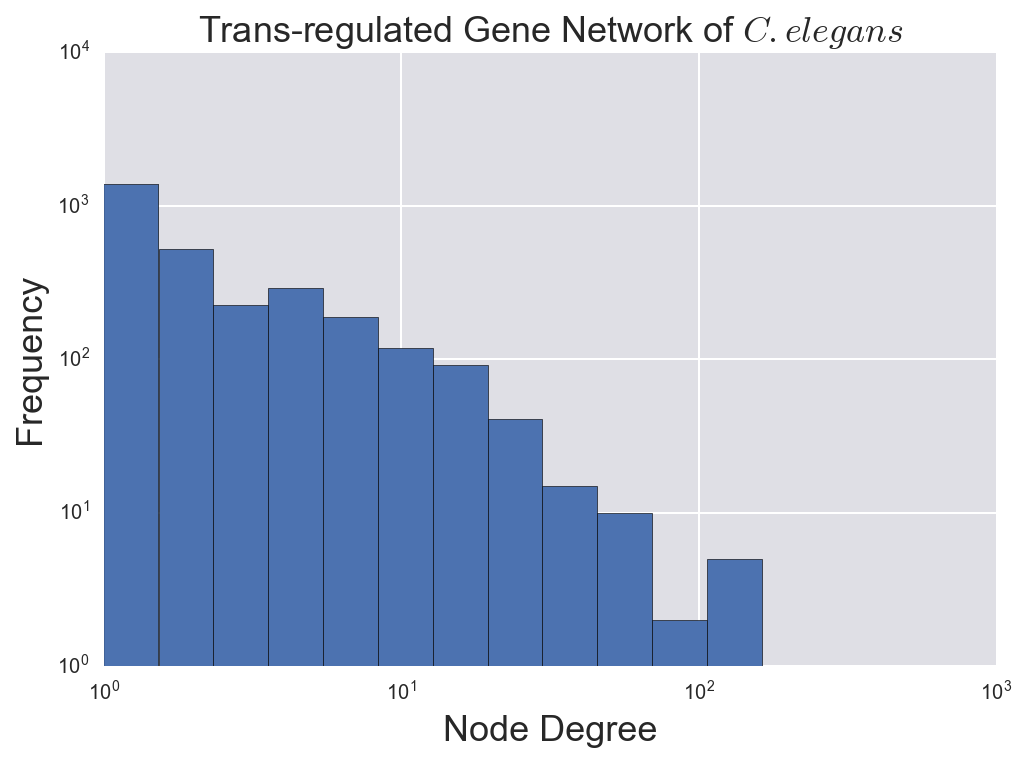

In [23]:
n_bins= np.floor(np.cbrt(len(val))) #rule of thumb, but use cbrt since we are using log-bins
MIN= min(val)
MAX= max(val)

#plot histogram with log spaced bins
plt.hist(val, bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), n_bins))

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel('Node Degree')
plt.gca().set_ylabel('Frequency')
plt.gca().set_title(r'Trans-regulated Gene Network of $C. elegans$')
plt.savefig('../output/Trans-regulated Gene Network of C. elegans.png')

In [13]:
conn_comp= nx.connected_component_subgraphs(nx.Graph(g))

In [15]:
print(nx.degree_histogram(g))

[0, 1377, 526, 224, 176, 117, 67, 68, 53, 39, 29, 24, 27, 28, 14, 21, 12, 5, 5, 7, 4, 9, 5, 3, 7, 2, 4, 3, 2, 2, 4, 1, 0, 2, 0, 0, 3, 1, 0, 0, 0, 1, 0, 0, 3, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


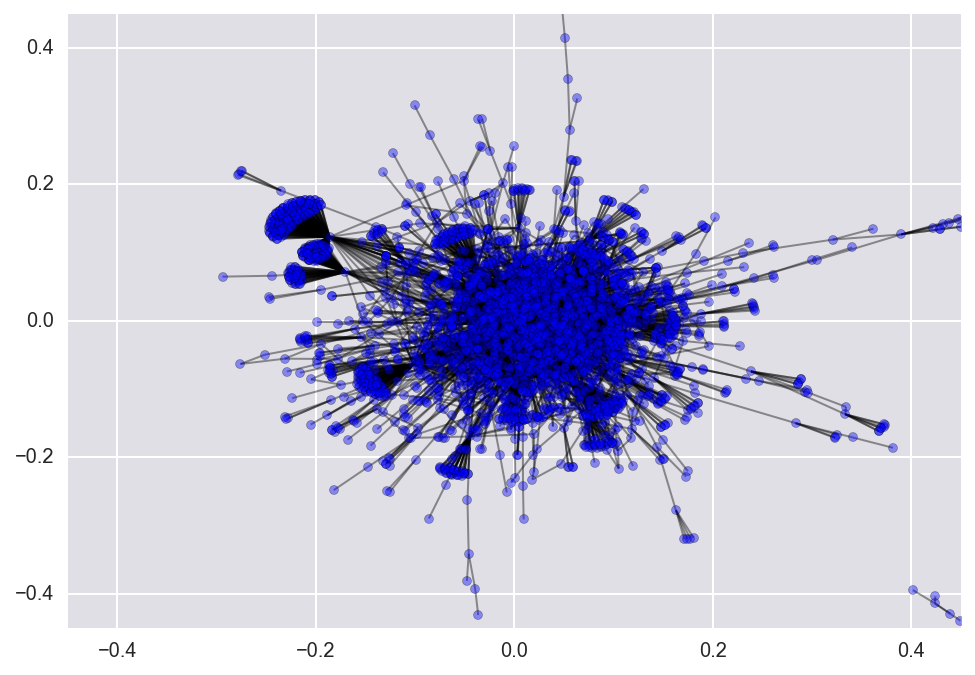

In [27]:
nx.draw_networkx(g, node_size= 20, alpha= 0.4, node_color='blue', with_labels=False)
plt.xlim(-.45, .45)
plt.ylim(-.45,.45)
plt.savefig('../output/trans_reg_worm_network_zoom_in.png')

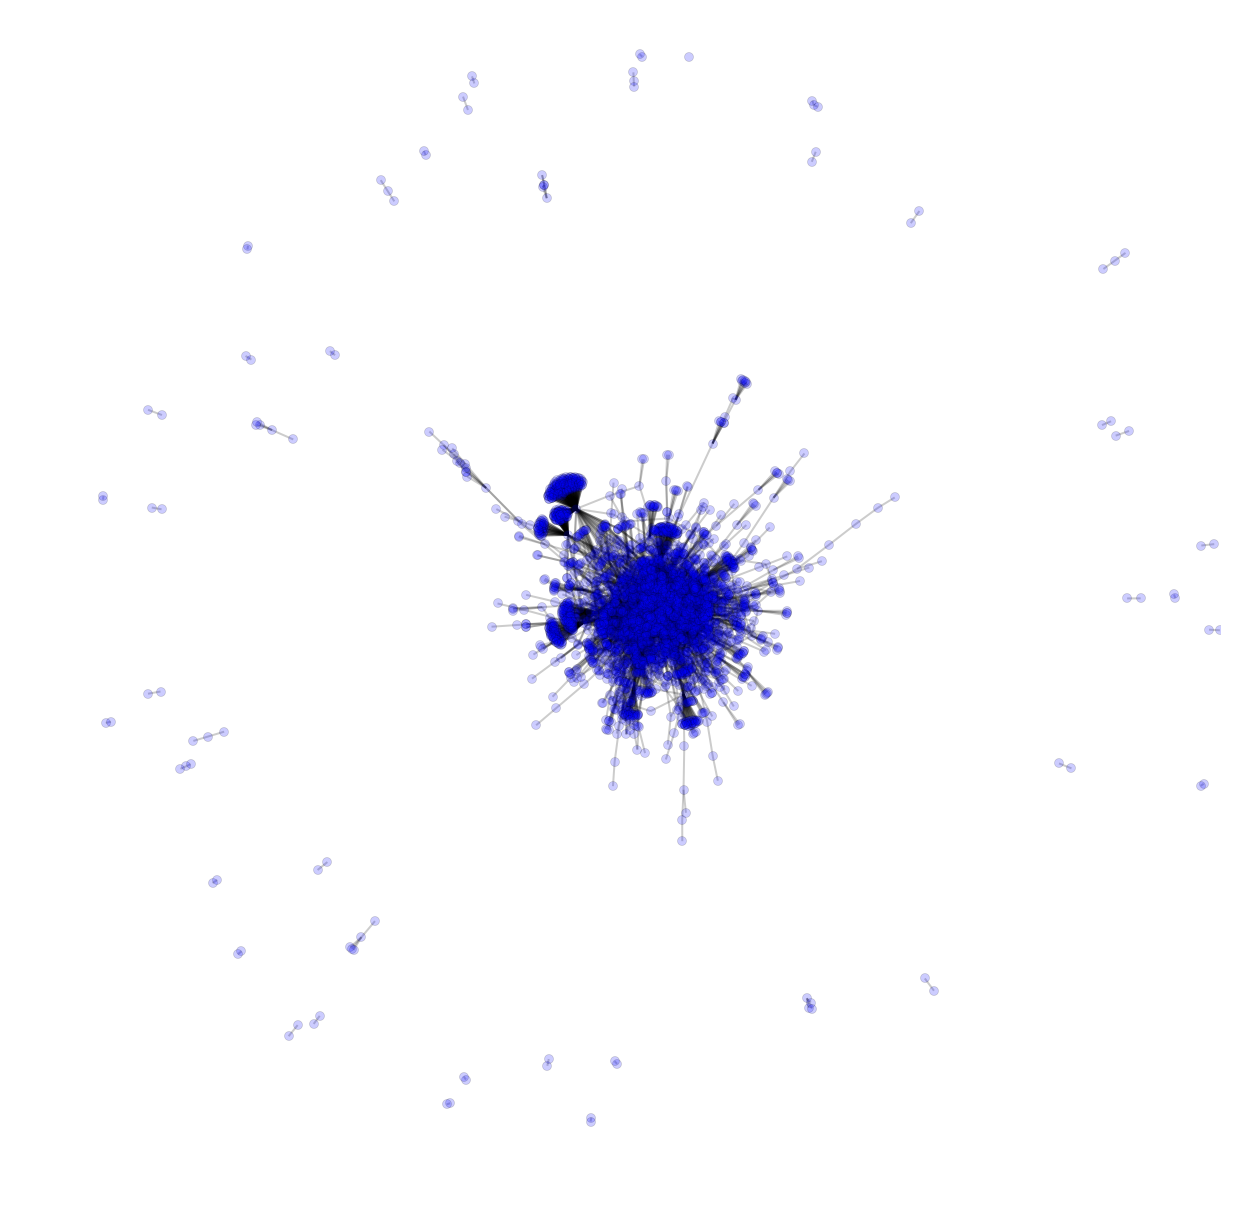

In [22]:
plt.figure(figsize=(8,8))
nx.draw_spring(g,node_size=20, alpha=0.2,node_color="blue", with_labels=False)
plt.axis('equal')
plt.xlim(-1, 1)
plt.ylim(-1,1)
plt.savefig('../output/trans_reg_worm_network.png')


In [ ]:
mc= max_clique(nx.Graph(g))

In [84]:
from networkx.algorithms.approximation import ramsey
__author__ = """Nicholas Mancuso (nick.mancuso@gmail.com)"""
__all__ = ["clique_removal","max_clique"]

def max_clique(G):
    r"""Find the Maximum Clique

    Finds the `O(|V|/(log|V|)^2)` apx of maximum clique/independent set
    in the worst case.

    Parameters
    ----------
    G : NetworkX graph
        Undirected graph

    Returns
    -------
    clique : set
        The apx-maximum clique of the graph

    Notes
    ------
    A clique in an undirected graph G = (V, E) is a subset of the vertex set
    `C \subseteq V`, such that for every two vertices in C, there exists an edge
    connecting the two. This is equivalent to saying that the subgraph
    induced by C is complete (in some cases, the term clique may also refer
    to the subgraph).

    A maximum clique is a clique of the largest possible size in a given graph.
    The clique number `\omega(G)` of a graph G is the number of
    vertices in a maximum clique in G. The intersection number of
    G is the smallest number of cliques that together cover all edges of G.

    http://en.wikipedia.org/wiki/Maximum_clique

    References
    ----------
    .. [1] Boppana, R., & Halldórsson, M. M. (1992).
        Approximating maximum independent sets by excluding subgraphs.
        BIT Numerical Mathematics, 32(2), 180–196. Springer.
        doi:10.1007/BF01994876
    """
    if G is None:
        raise ValueError("Expected NetworkX graph!")

    # finding the maximum clique in a graph is equivalent to finding
    # the independent set in the complementary graph
    cgraph = nx.complement(G)
    iset, _ = clique_removal(cgraph)
    return iset

def clique_removal(G):
    """ Repeatedly remove cliques from the graph.

    Results in a `O(|V|/(\log |V|)^2)` approximation of maximum clique
    & independent set. Returns the largest independent set found, along
    with found maximal cliques.

    Parameters
    ----------
    G : NetworkX graph
        Undirected graph

    Returns
    -------
    max_ind_cliques : (set, list) tuple
        Maximal independent set and list of maximal cliques (sets) in the graph.

    References
    ----------
    .. [1] Boppana, R., & Halldórsson, M. M. (1992).
        Approximating maximum independent sets by excluding subgraphs.
        BIT Numerical Mathematics, 32(2), 180–196. Springer.
    """
    graph = G.copy()
    c_i, i_i = ramsey.ramsey_R2(graph)
    cliques = [c_i]
    isets = [i_i]
    while graph:
        graph.remove_nodes_from(c_i)
        c_i, i_i = ramsey.ramsey_R2(graph)
        if c_i:
            cliques.append(c_i)
        if i_i:
            isets.append(i_i)

    maxiset = max(isets)
    return maxiset, cliques


In [78]:
def power_law(nodes, alpha):
    """
    A function to model power-law growth of a network
    """

    if np.min(alpha)> 0:
        return nodes**-alpha
    else:
        raise RuntimeError('alpha range includes values less than 0, please specify only positive alpha') 
        
def mle_power_law(data, alpha):
    if max(data) != 1:
        data= data/max(data)
    
    nodes= np.linspace(1, len(data), len(data)) #number of nodes
    log_mle= -len(d)/2*np.log(np.sum(data[0] - power_law(nodes, alpha)**2))
    
    return np.exp(log_mle)

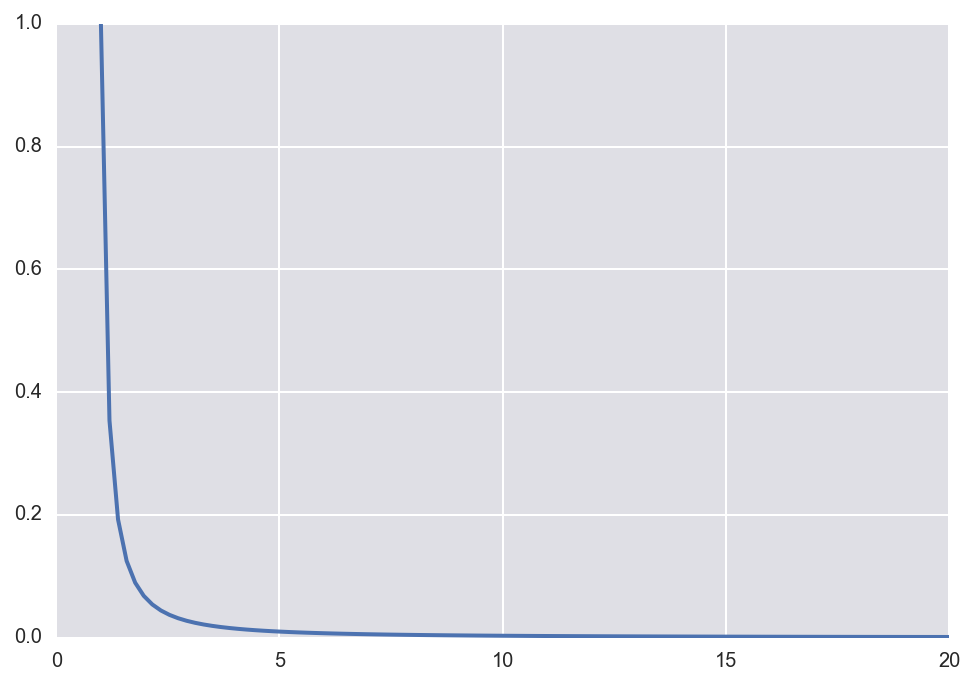

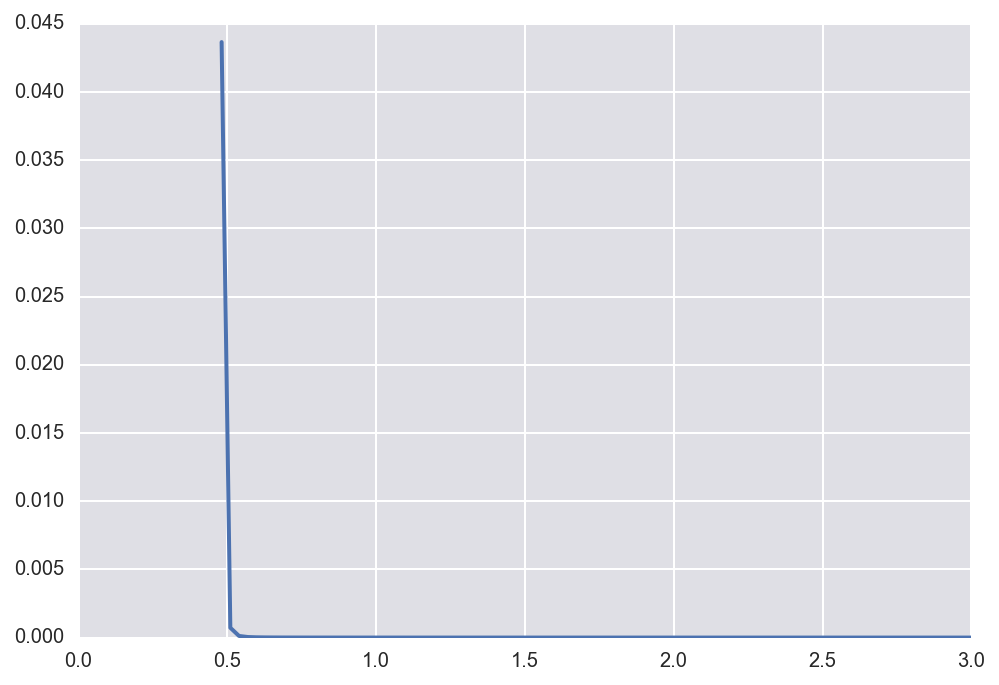

In [81]:
x= np.linspace(1, 20, 100)
y= power_law(nodes, 1.5)
plt.plot(x, y)

alpha= np.linspace(0.1, 3, 100)
mle= []
for a in alpha:
    mle.append(mle_power_law(val, a))

fig, ax= plt.subplots()
ax.plot(alpha, mle)

In [83]:
mle[0]

nan

In [64]:
val.shape

(2893,)

In [65]:
val[0]

1